In [1]:
from IPython.core.display import HTML
from IPython.display import Video

def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()

# for the purpose of readability, we will move the functions for the animations,
# the necessary imports, and the method to generate synthetic data to the beginning of the notebook
import acoular as ac
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FFMpegWriter

def init_animation_fixed_focus(rg, micgeom, trs, lz, col):
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, num=1)
    ax.set(xlabel='x', ylabel='y', zlabel='z')
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.set_zlim(0, lz)
    # Plot microphone positions
    ax.scatter(micgeom.pos[0], micgeom.pos[1], micgeom.pos[2], 'o', label='mics')
    # Plot static grid elements
    gpos = rg.pos.reshape((3, rg.nxsteps, rg.nysteps))
    ax.plot_wireframe(gpos[0], gpos[1], gpos[2], color='k', lw=0.2, label='grid')
    # Initialize scatter plots for sources
    scatter_plots = [
        ax.scatter([], [], [], label=f'source {i}', color=col[i]) for i in range(len(trs))
    ]
    fig.legend()
    plt.close(fig)  # Close figure to prevent extra display in notebooks
    return fig, ax, scatter_plots

def update_frame_fixed_focus(frame, scatter_plots, trs, t_pass, ax):
    ttime = frame * (t_pass / 100)
    # Update scatter plots
    for i, tr in enumerate(trs):
        loc = tr.location(ttime)
        scatter_plots[i]._offsets3d = (
            [loc[0]],
            [loc[1]],
            [loc[2]]
        )
    # Update dynamic title with current time
    ax.set_title(f't = {ttime:.2f}s')
    return scatter_plots 

def init_animation_moving_focus(rgm, tr0, trs, micgeom, t_pass, lz, col):
    # Create figure and 3D axes
    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, num=1)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)
    ax.set_zlim(0, lz)
    state={}
    # Plot microphone positions
    ax.scatter(micgeom.pos[0], micgeom.pos[1], micgeom.pos[2], 'o', label='mics')
    # At t=0, compute the grid's global coordinates and plot as wireframe.
    gpos = rgm.pos.reshape((3, rgm.nxsteps, rgm.nysteps)) + np.array(tr0.location(0))[:, None, None]
    state['grid_wire'] = ax.plot_wireframe(gpos[0], gpos[1], gpos[2],
                                  color='k', lw=0.2, label='grid')
    # Initialize scatter plots for sources
    state['scatter_plots'] = [
        ax.scatter([], [], [], label=f'source {i}', color=col[i]) for i in range(len(trs))
    ]
    fig.legend()
    plt.close(fig)  # Prevent immediate display in notebooks
    return fig, ax, state

def update_frame_moving_focus(frame, state, rgm, tr0, trs, col, ax):
    ttime = frame * (t_pass / 100)
    # Update grid wireframe
    new_gpos = rgm.pos.reshape((3, rgm.nxsteps, rgm.nysteps)) + np.array(tr0.location(ttime))[:, None, None]
    # Remove the old grid wireframe lines
    if isinstance(state['grid_wire'], (list, tuple)):
        for line in state['grid_wire']:
            line.remove()
    else:
        state['grid_wire'].remove() # Remove last line
    state['grid_wire'] = ax.plot_wireframe(new_gpos[0], new_gpos[1], new_gpos[2],
                                            color='k', lw=0.2)
    # Update scatter plots 
    for i, tr in enumerate(trs):
        loc = tr.location(ttime)
        state['scatter_plots'][i]._offsets3d = (
            [loc[0]],
            [loc[1]],
            [loc[2]]
        )
    # Update dynamic title with current time
    ax.set_title(f't = {ttime:.2f}s')
    return state['scatter_plots'] + [state['grid_wire']]

def generate_synth_data(sfreq, num_samples, lx, lz):
    nseed = 1
    convamp = True 
    # Initialize 4 different WNoiseGenerator objects. 
    sig1 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=nseed    , rms=0.564) # 89 dB
    sig2 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=nseed + 1, rms=0.4) # 86 dB
    sig3 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=nseed + 2, rms=0.283) # 83 dB
    sig4 = ac.WNoiseGenerator(sample_freq=sfreq, num_samples=num_samples, seed=nseed + 3, rms=0.2) # 80 dB

    sigs = [sig1, sig2, sig3, sig4]


    # Define source positions
    sp1 = ( 1,  1, 0)
    sp2 = ( 1, -1, 0)
    sp3 = (-1, -1, 0)
    sp4 = (-1,  1, 0)
    
    # helper method to create linear trajectories in reference origin of the 
    # source configuration
    def create_trajectory(sp):
        return ac.Trajectory(points={0:(-lx+sp[0],sp[1],lz+sp[2]),
                                     t_pass:(lx+sp[0],sp[1],lz+sp[2])})
       
    source_pos = [sp1, sp2, sp3, sp4]

    tr1 = create_trajectory(sp1)
    tr2 = create_trajectory(sp2)
    tr3 = create_trajectory(sp3)
    tr4 = create_trajectory(sp4)

    trs = [tr1, tr2, tr3, tr4]

    # Create MovingPointSource instances for each noise signal
    mps1 = ac.MovingPointSource(signal=sig1, mics=micgeom, trajectory=tr1, conv_amp=convamp)
    mps2 = ac.MovingPointSource(signal=sig2, mics=micgeom, trajectory=tr2, conv_amp=convamp)
    mps3 = ac.MovingPointSource(signal=sig3, mics=micgeom, trajectory=tr3, conv_amp=convamp)
    mps4 = ac.MovingPointSource(signal=sig4, mics=micgeom, trajectory=tr4, conv_amp=convamp)
    
    # Color coding for sources
    col = ['red', 'blue', 'orange', 'green']

    # Create SourceMixer with all point sources
    source_mixer = ac.SourceMixer(sources=[mps1, mps2, mps3, mps4])
    return trs, col, source_mixer

# generate animation for fixed focus
def gen_ani_ff(rg, micgeom, trs, lz, col):
    fig, ax, scatter_plots = init_animation_fixed_focus(rg, micgeom, trs, lz, col)
    ani = animation.FuncAnimation(
        fig,
        update_frame_fixed_focus,
        frames=101,
        interval=50,
        blit=False,
        fargs=(scatter_plots, trs, t_pass, ax)
    )
    writer = FFMpegWriter(fps=15, metadata=dict(artist='Acoular'), bitrate=1800)
    HTML(ani.to_jshtml())
    ani.save("./vid/fixed_focus.mp4", writer=writer)
    
# generate animation for fixed focus
def gen_ani_mv(rgm, tr0, trs, micgeom, t_pass, lz, col):
    fig, ax, state = init_animation_moving_focus(
        rgm, tr0, trs, micgeom, t_pass, lz, col
    )
    ani = animation.FuncAnimation(
        fig,
        update_frame_moving_focus,
        frames=101,
        fargs=(state, rgm, tr0, trs, col, ax),
        interval=50,
        blit=False
    )
    writer = FFMpegWriter(fps=15, metadata=dict(artist='Acoular'), bitrate=1800)
    HTML(ani.to_jshtml())
    ani.save("./vid/moving_focus.mp4", writer=writer)
    
def plot_maps(res, gird, block_size, sfreq):
    nsize = int(np.ceil((np.sqrt(len(res)))))
    plt.figure(figsize=(8, 7))
    for i,r in enumerate(res):
        r0 = r.reshape(gird.shape)
        plt.subplot(nsize, nsize, i+1)
        mx = ac.L_p(r0.max())
        plt.imshow(
            ac.L_p(np.transpose(r0)), vmax=mx, vmin=mx - 15, interpolation='nearest', extent=gird.extend(), origin='lower'
        )
        plt.title(f"t = {(i)*block_size/sfreq}")
        plt.colorbar()
    plt.tight_layout()

Path('./cache/03').mkdir(parents=True, exist_ok=True)
ac.config.cache_dir = './cache/03'

<img src="img/DAGA_logo.png" alt="DAGA Logo" style="width:160px; position:absolute; top:20px; right:0px;">
<img src="img/TU-lang.png" alt="TU Logo" style="width:230px; position:absolute; top:0px; right:180px;">

<h1 style="margin-top: 180px; margin-bottom: 50px; color: #A81D1E;">Beamforming in the time domain with moving sources</h1>
<h3 style="margin-top: 50px; margin-bottom: 100px; color: #434343;">Mikolaj Czuchaj, Gert Herold, Adam Kujawski, Oliver Lylloff, Art J. R. Pelling, Ennes Sarradj</h3>

<h5 style="margin-top: 50px; margin-bottom: 100px; color: #434343;">Jupyter Notebook available at <a href="https://github.com/acoular/workshop_DAS-DAGA-2025">https://github.com/acoular/workshop_DAS-DAGA-2025</a></h5>

- analysis of moving sources in many possible applications, such as train, car, or airplane pass-bys
- this notebook demonstrates the analysis of moving sources with Acoular, using fixed and moving focus time-domain beamforming, as well as the application of moving focus CLEANT

## 1. Synthetic data

![Sketch](./img/sketch_moving_sources.png "Sketch")

- synthetic input data consisting of four white noise monopole acoustic sources moving in front of the array
- lz is the distance between the plane in which the sources move and the array plane, and lx is the distance to the starting position on the x-axis
- sources moving with a velocity v of 60 km/h
- simulated microphone array data with a sample rate of 51200, consisting of the entire pass-by of the sources from -lx to lx

In [2]:
lx = 5 # m, distance to start position on x-axis 
lz = 10 # m, distance between array and source plane
v = 60 # km/h, source velocity
vx_m = v/3.6 # m/s, source velocity converted to meters per second
t_pass = 2 * lx / vx_m  # s, total pass-by duration
sfreq = 12800 # Hz, sampling frequency
num_samples = int(t_pass * sfreq) # total number of samples
block_size = int(num_samples/16) # number of samples per processing block
freq = 4000  # Hz, third-octave band used for analysis

- we use a configuration of 64 microphones as our microphone array

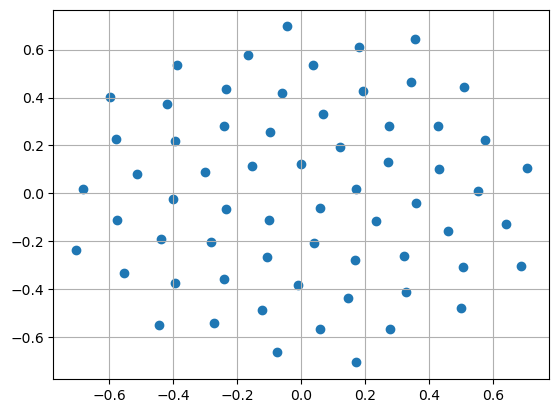

In [3]:
micgeom = ac.MicGeom(file=Path(ac.__file__).parent / 'xml' / 'tub_vogel64.xml') # selected microphone geometry
plt.scatter(micgeom.pos[0], micgeom.pos[1])
plt.grid()

- a linear translational trajectory can be modeled using the `Trajectory` class
- the trajectory is defined by assigning discrete time instants (keys) to sampled (x, y, z) positions along the trajectory; based on these points, a continuous trajectory is calculated
- a linear trajectory with constant speed can be defined by specifying two points of the trajectory
<!-- - we model our synthetic data by first defining the signal with a signal generator in the case of white noise we use WNoiseGenerator, with given sample frequency, number of samples, a seed and an rms value
- in order to generate the sythetic data of a moving source we use the MovingPointSouce class with the previouse signal, the trajectory and microphone array geometry
- finally we mix the four sources using the ax.SourceMixer class, and define a Cache for it so that we do not have to regenerate it -->

In [4]:
# trajectory of the origin of the source configuration
tr0 = ac.Trajectory(points={0:(-lx,0,lz),t_pass:(lx,0,lz)})
trs, col, source_mixer = generate_synth_data(sfreq, num_samples, lx, lz)

## 2. Beamforming in the time domain with fixed focus

<!-- $$
b(t, x_g, p_m) = \frac{1}{K_{x_g}(t)} \sum_{m=1}^{N} w_m \frac{p_m\left(t + \frac{r_{x_g m}(t)}{c}\right)}{r_{x_g m}(t) \left(1 - M \cos \left(\theta_{x_g m}(t)\right)\right)^2}
$$

$$
K_{x_g}(t) = \sum_{m=1}^{N} \frac{w_m}{\left[r_{x_g m}(t) \left(1 - M \cos \left(\theta_{x_g m}(t)\right)\right)^2\right]^2}
$$                 -->

- beamforming in the time domain with fixed focus consists of summing the time-delayed and amplitude-modified microphone signals on a defined grid
- here we use a rectangular grid defined by the `RectGrid` class, measuring 8 m by 4 m with an increment of 0.1 m between each grid point, resulting in a total of 81 × 41 = 3321 points

In [5]:
rg = ac.RectGrid(x_min=-4, x_max=4,y_min=-2, y_max=2,z=lz, increment=0.1 )
st = ac.SteeringVector(grid=rg, mics=micgeom)

In [6]:
# uncomment if you want to generate the animation
# gen_ani_ff(rg, micgeom, trs, lz, col)
Video("./vid/fixed_focus.mp4")

- create processing chain for fixed focus beamforming
<div style="display: flex;">
  <!-- Left column with two images stacked vertically -->
  <div style="display: flex; flex-direction: column; margin-right: 10px;">
    <img src="./img/pipeline_01.svg" width="600" style="margin-bottom: 10px;">
  </div>
  <!-- Right column with one image -->
  <div>
    <img src="./img/chain.png" width="100">
  </div>
</div>
<img src="./img/pipeline_02.svg" width="800">

In [7]:
fi = ac.FiltFiltOctave(source=source_mixer, band=freq, fraction='Third octave')
bt = ac.BeamformerTimeSq(source=fi, steer=st, r_diag=True)
avgt = ac.Average(source=bt, num_per_average=block_size)  # 15 single images
cacht = ac.Cache(source=avgt)  # cache to prevent recalculation

[('void_cache.h5', 1)]


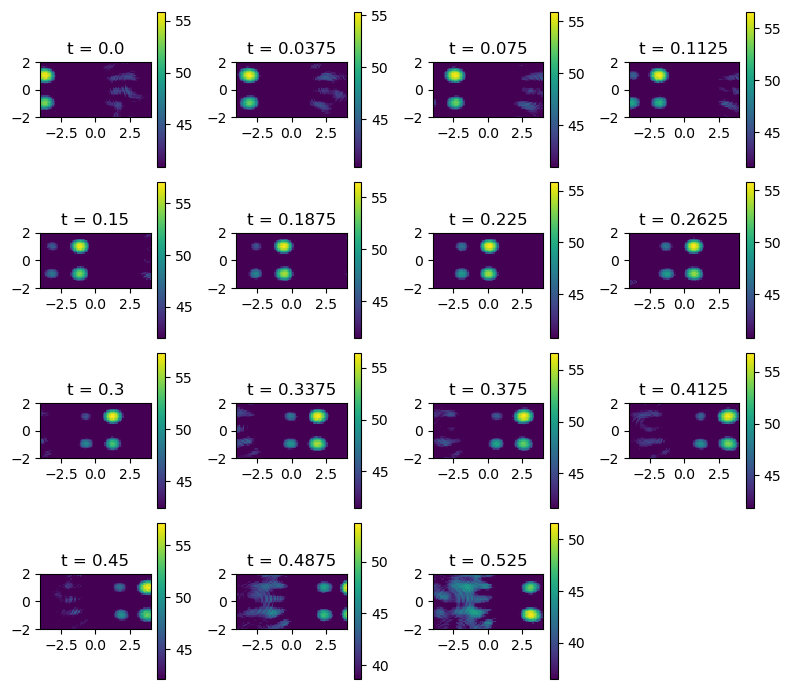

In [8]:
res = ac.tools.return_result(cacht,num=1)
plot_maps(res, rg, block_size, sfreq)

## 3. Beamforming in the time domain with moving focus

- we use a smaller rectangular grid of 4 m by 4 m with an increment of 0.1 m between each grid point, resulting in a total of 41 × 41 = 1681 points

In [9]:
rgm = ac.RectGrid(x_min=-2, x_max=2,y_min=-2, y_max=2,z=0, increment=0.1)
st = ac.SteeringVector(grid=rgm, mics=micgeom)

In [10]:
# uncomment if you want to generate the animation
# gen_ani_mv(rgm, tr0, trs, micgeom, t_pass, lz, col)
Video("./vid/moving_focus.mp4")

- create processing of chain moving focus Beamforming
- use of `BeamformerTimeSqTraj` in processing chain with set `trajectory`

In [11]:
fi = ac.FiltFiltOctave(source=source_mixer, band=freq, fraction='Third octave')
bt = ac.BeamformerTimeSqTraj(source=fi, steer=st, trajectory=tr0, r_diag=True)
avgt = ac.Average(source=bt, num_per_average=block_size)  # 15 single images
cacht = ac.Cache(source=avgt)  # cache to prevent recalculation

[('void_cache.h5', 2)]


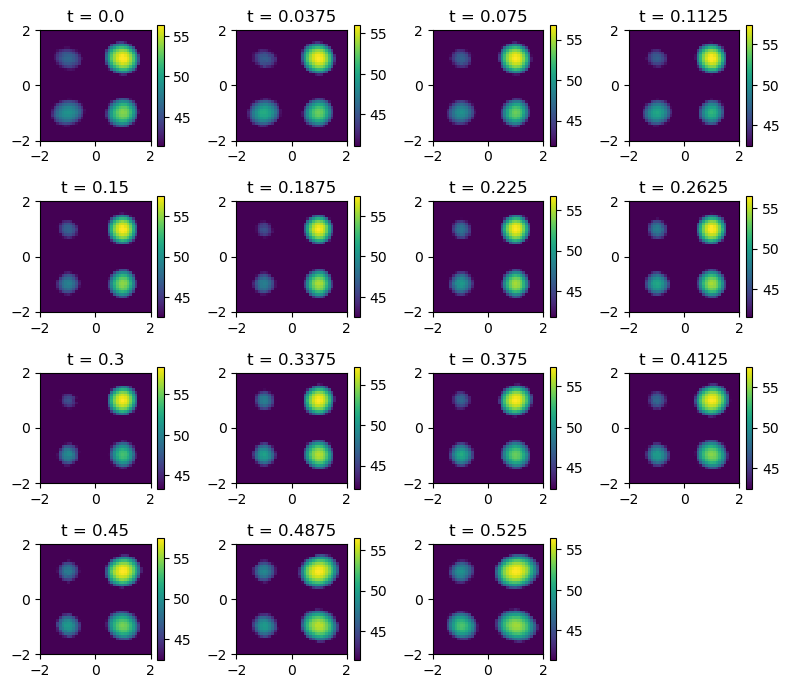

In [12]:
res = ac.tools.return_result(cacht,num=1)
plot_maps(res, rgm, block_size, sfreq)

## 4. Beamforming with deconvolution (CLEANT) in the time domain with moving focus


<!-- ###### **Cleant* <a href="https://www.sciencedirect.com/science/article/abs/pii/S0022460X18307880">[1]</a>:  -->
<!-- 
$$
\Phi^{(0)}(t, x_g) = b(t, x_g, \{ p_m \}),\quad \Gamma^{(0)}(t, x_g) = 0,\quad p_m^{res(0)}(t) = p_m(t)
$$


$$
\hat{x}_g = \underset{x_g}{\text{argmax}} \left( \int_T |\Phi^{(i-1)}(t, x_g)|^2\, dt \right)
$$

$$
\Gamma^{(i)}(t, \hat{x}_g) = \Gamma^{(i-1)}(t, \hat{x}_g) + \gamma \Phi^{(i-1)}(t, \hat{x}_g)
$$

$$
p_m^{res(i)}\left(t + \frac{r_{x_g m}}{c}\right) = p_m^{res(i-1)}\left(t + \frac{r_{x_g m}}{c}\right) - \gamma \frac{\Phi^{(i-1)}(t, \hat{x}_g)}{r_{\hat{x}_g m}(t) \left(1 - M \cos\left(\theta_{\hat{x}_g m}(t)\right)\right)^2}
$$

$$
\Phi^{(i)}(t, x_g) = b(t, x_g, \{ p_m^{res(i)} \})
$$ -->

- use of `BeamformerCleantSqTraj` in processing pipeline based on *CLEANT* <a href="https://www.sciencedirect.com/science/article/abs/pii/S0022460X18307880">[1]  
  

In [13]:
fi = ac.FiltFiltOctave(source=source_mixer, band=freq, fraction='Third octave')
bt = ac.BeamformerCleantSqTraj(source=fi, steer=st, trajectory=tr0, conv_amp=True)
avgt = ac.Average(source=bt, num_per_average=block_size)  # 15 single images
cacht = ac.Cache(source=avgt)  # cache to prevent recalculation

[('void_cache.h5', 3)]


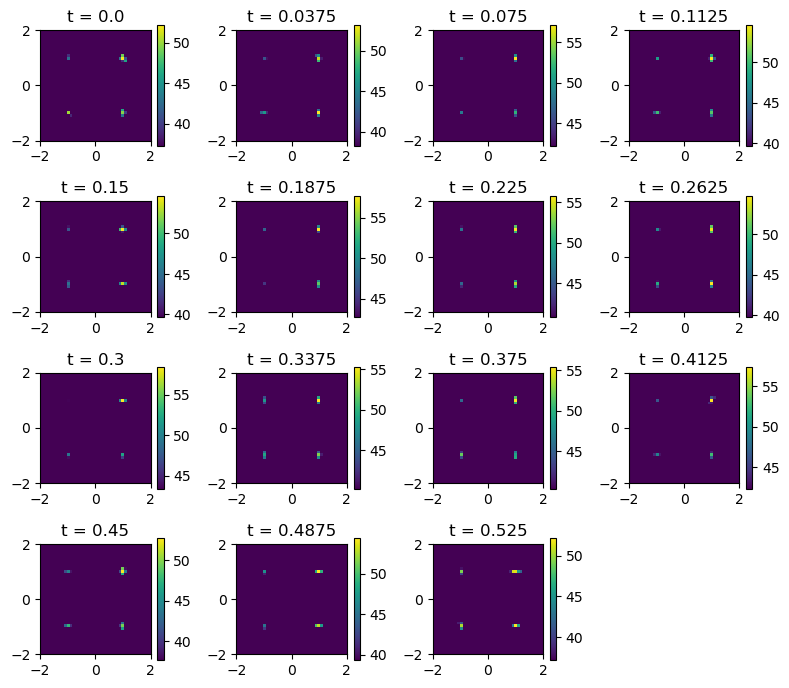

In [14]:
res = ac.tools.return_result(cacht,num=1)
plot_maps(res, rgm, block_size, sfreq)

<h2>References</h2>
(1)</div><div class="csl-right-inline" style="margin: 0 .4em 0 1.5em;">Cousson, R.; Leclère, Q.; Pallas, M.-A.; Bérengier, M. A Time Domain CLEAN Approach for the Identification of Acoustic Moving Sources. <i>Journal of Sound and Vibration</i> 2019, <i>443</i>, 47–62. <a href="https://doi.org/10.1016/j.jsv.2018.11.026">https://doi.org/10.1016/j.jsv.2018.11.026</a>.</div>